## 🧩 Importación de librerias y lectura del dataset principal
### *Análisis Exploratorio de Datos Hospitalarios (2005–2023)*

In [19]:
# ===============================================================
# 1. Carga del dataset base — XGBoost
# ===============================================================

import pandas as pd
import numpy as np
import os
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import json
import warnings
warnings.filterwarnings("ignore")

# Cargar el dataset base
df = pd.read_csv("/Users/facundoa.sardo/Desktop/No Country/data/dataset_centros_capacidad.xls")
print(f"Dataset cargado correctamente: {df.shape[0]:,} registros y {df.shape[1]} variables.")

Dataset cargado correctamente: 70,558 registros y 31 variables.


In [20]:
# ===============================================================
# 2. Variables externas para el modelo — XGBoost
# ===============================================================

# Clima (frío / templado / calor) según el mes
def clasificar_clima(mes: int) -> str:
    if mes in (6, 7, 8):
        return "frio"
    if mes in (12, 1, 2):
        return "calor"
    return "templado"

df["clima"] = df["mes"].apply(clasificar_clima)

# Feriados (meses con mayor cantidad de feriados o fines de semana largos)
def marcar_feriados(mes: int) -> int:
    return 1 if mes in (3, 4, 5, 7, 12) else 0

df["feriados"] = df["mes"].apply(marcar_feriados)

# Covid (1 en 2020-2021, 0 en el resto)
df["covid_dummy"] = df["anio"].apply(lambda anio: 1 if anio in (2020, 2021) else 0)

# Eliminar dummies previas si existían
for columna in ("clima_calor", "clima_frio", "clima_templado"):
    if columna in df.columns:
        df.drop(columns=columna, inplace=True)

# One-hot encoding de clima sin descartar categorías
df = pd.get_dummies(df, columns=["clima"], drop_first=False)

print("Variables externas creadas y codificadas correctamente.")
print(df[["anio", "mes", "feriados", "covid_dummy", "clima_calor", "clima_frio", "clima_templado"]].head())

Variables externas creadas y codificadas correctamente.
   anio  mes  feriados  covid_dummy  clima_calor  clima_frio  clima_templado
0  2005    1         0            0         True       False           False
1  2005    2         0            0         True       False           False
2  2005    3         1            0        False       False            True
3  2005    4         1            0        False       False            True
4  2005    5         1            0        False       False            True


*Primero, se crea una columna de clima, donde cada mes se clasifica como frío, templado o cálido según la época del año. Después, se genera una columna de feriados, marcando con un 1 los meses que suelen tener más feriados o fines de semana largos en Argentina (como marzo, abril, mayo, julio y diciembre). Luego, se incorpora una variable llamada covid_dummy, que marca con un 1 los años 2020 y 2021 para indicar el impacto del COVID-19, y con un 0 el resto. Finalmente, el clima se convierte en variables numéricas (llamadas “dummies”) para que los modelos de machine learning puedan interpretarlas fácilmente*

In [21]:
# ---------------------------------------------------------------
# 2.B Actualización de feriados específicos
# ---------------------------------------------------------------
df["fecha"] = pd.to_datetime(
    df["anio"].astype(str) + "-" + df["mes"].astype(str) + "-01",
    errors="coerce",
)

feriados_arg = {
    (1, 1),    # Año Nuevo
    (2, 20),   # Carnaval (día 1)
    (2, 21),   # Carnaval (día 2)
    (3, 24),   # Día de la Memoria
    (4, 14),   # Viernes Santo
    (5, 1),    # Día del Trabajador
    (5, 25),   # Revolución de Mayo
    (6, 17),   # Güemes
    (6, 20),   # Bandera
    (7, 9),    # Independencia
    (8, 15),   # San Martín
    (10, 7),   # Diversidad Cultural
    (10, 12),  # Encuentro de Dos Mundos
    (11, 20),  # Soberanía Nacional
    (12, 8),   # Inmaculada Concepción
    (12, 25),  # Navidad
}

df["feriados"] = df["fecha"].apply(lambda fecha: 1 if (fecha.month, fecha.day) in feriados_arg else 0)

print("Columna 'feriados' actualizada correctamente con fechas específicas.")
print(df[["fecha", "feriados"]].head(20))

Columna 'feriados' actualizada correctamente con fechas específicas.
        fecha  feriados
0  2005-01-01         1
1  2005-02-01         0
2  2005-03-01         0
3  2005-04-01         0
4  2005-05-01         1
5  2005-06-01         0
6  2005-07-01         0
7  2005-08-01         0
8  2005-09-01         0
9  2005-10-01         0
10 2005-11-01         0
11 2005-12-01         0
12 2005-01-01         1
13 2005-02-01         0
14 2005-03-01         0
15 2005-04-01         0
16 2005-05-01         1
17 2005-06-01         0
18 2005-07-01         0
19 2005-08-01         0


*Primero, se combina el año y el mes de cada registro para formar una fecha completa, usando el primer día de cada mes como referencia. Luego, se define una lista de feriados fijos (como Año Nuevo, Carnaval, Día de la Memoria, Independencia o Navidad), guardando solo el mes y el día de cada uno. Después, se compara cada fecha del dataset con esta lista: si el mes coinciden con alguno de los feriados, se marca con un 1, y si no, con un 0.
El resultado es una nueva columna llamada “feriados”, que permite al modelo saber si un determinado registro corresponde a un mes o día con feriados, lo que puede influir en la demanda o actividad hospitalaria*

In [22]:
# ===============================================================
# 3. Preparación de datos y variables temporales
# ===============================================================

# Ordenar los datos por hospital y fecha
df.sort_values(["establecimiento_nombre", "anio", "mes"], inplace=True)

# Normalizar variables continuas seleccionadas
columnas_normalizar = ["anio", "quirofanos", "medicos", "enfermeros"]
for columna in columnas_normalizar:
    if columna in df.columns:
        promedio = df[columna].mean()
        desviacion = df[columna].std(ddof=0) or 1
        df[f"{columna}_norm"] = (df[columna] - promedio) / desviacion

# Crear variables temporales (lags y medias móviles) para columnas clave
columnas_objetivo = ["consultas_medicas", "cirugias", "porcentaje_ocupacion"]

for columna in columnas_objetivo:
    grupo = df.groupby("establecimiento_nombre")[columna]
    df[f"{columna}_lag_1"] = grupo.shift(1)
    df[f"{columna}_lag_12"] = grupo.shift(12)
    df[f"{columna}_rolling_mean_3"] = (
        grupo.rolling(window=3, min_periods=1)
        .mean()
        .reset_index(level=0, drop=True)
        .shift(1)
    )

# Rellenar valores faltantes generados en lags y medias móviles
columnas_lag = [
    columna for columna in df.columns if "_lag_" in columna or "_rolling_mean_" in columna
]
df[columnas_lag] = df[columnas_lag].fillna(0)

print("Datos ordenados, normalizados y variables temporales creadas correctamente.")

Datos ordenados, normalizados y variables temporales creadas correctamente.


*Primero, los registros se ordenan por hospital y por fecha (año y mes), lo que asegura que los datos estén en el orden correcto para generar variables históricas. Luego, se normalizan algunas columnas numéricas como año, cantidad de quirófanos, médicos y enfermeros para que todas estén en una escala similar, facilitando el trabajo de los modelos de machine learning.
Después, se crean variables temporales llamadas lags (valores del mes anterior o del mismo mes del año pasado) y medias móviles, que calculan el promedio de los últimos tres meses para cada hospital. Estas variables permiten que el modelo tenga en cuenta la evolución reciente de las consultas, cirugías y porcentaje de ocupación.
Por último, se rellenan los valores faltantes con ceros para evitar errores en el entrenamiento y se confirma que los datos quedaron ordenados, normalizados y listos para usarse en la etapa de modelado*

In [23]:
# ===============================================================
# 4. Filtrado de hospitales activos
# ===============================================================

# Copia de trabajo y normalización del nombre del establecimiento
mem = df.copy()
mem["establecimiento_nombre"] = mem["establecimiento_nombre"].str.upper().str.strip()

# Selección de registros con actividad hospitalaria relevante
activos = mem[(mem["consultas_medicas"] > 0) & (mem["porcentaje_ocupacion"] > 0)]

# Persistencia del dataset filtrado
output_path = "proyecciones_filtradas.csv"
activos.to_csv(output_path, index=False, encoding="utf-8")

print(f"Dataset filtrado guardado en: {output_path}")
print(f"Filas activas: {activos.shape[0]:,} | Establecimientos únicos: {activos['establecimiento_nombre'].nunique():,}")

Dataset filtrado guardado en: proyecciones_filtradas.csv
Filas activas: 62,698 | Establecimientos únicos: 341


*Primero, se crea una copia del conjunto de datos original y se estandarizan los nombres de los hospitales, convirtiéndolos a mayúsculas y eliminando espacios extra. Luego, se filtran solo aquellos registros donde haya consultas médicas y porcentaje de ocupación mayores a cero, es decir, hospitales que efectivamente tuvieron actividad en ese período.
Después, el dataset resultante se guarda en un nuevo archivo llamado proyecciones_filtradas.csv, que servirá como base para realizar predicciones desde la API. Finalmente, el código muestra en pantalla cuántas filas tiene el archivo y cuántos hospitales activos fueron detectados, confirmando que el filtrado se realizó correctamente*

In [24]:
# ===============================================================
# 5. Preparación, entrenamiento y persistencia — Modelos XGBoost
# ===============================================================

df = pd.read_csv("proyecciones_filtradas.csv")
print(f"Dataset filtrado cargado: {df.shape[0]:,} filas y {df.shape[1]} columnas.")

# Clima a formato numérico
for columna in ("clima_frio", "clima_templado", "clima_calor"):
    if columna in df.columns:
        df[columna] = df[columna].fillna(0).astype(int)
print("Variables de clima convertidas a formato entero (0/1).")

# Eliminación de outliers extremos (percentil 99)
filas_originales = df.shape[0]
df = df[
    (df["consultas_medicas"] < df["consultas_medicas"].quantile(0.99))
    & (df["porcentaje_ocupacion"] < df["porcentaje_ocupacion"].quantile(0.99))
    & (df["cirugias"] < df["cirugias"].quantile(0.99))
    & (df["urgencias"] < df["urgencias"].quantile(0.99))
]
print(f"Filtrado de outliers completado: {df.shape[0]:,} filas conservadas (−{filas_originales - df.shape[0]:,}).")

# Componentes estacionales y normalización temporal
df["sin_mes"] = np.sin(2 * np.pi * df["mes"] / 12)
df["cos_mes"] = np.cos(2 * np.pi * df["mes"] / 12)
df["anio_norm"] = (df["anio"] - df["anio"].min()) / (df["anio"].max() - df["anio"].min())

# Ordenar para construir lags por establecimiento
df.sort_values(["establecimiento_nombre", "anio", "mes"], inplace=True)

# Variables rezagadas por hospital
lag_map = {
    "consultas_lag1": "consultas_medicas",
    "ocupacion_lag1": "porcentaje_ocupacion",
    "cirugias_lag1": "cirugias",
    "urgencias_lag1": "urgencias",
}
for nueva_columna, base_columna in lag_map.items():
    df[nueva_columna] = (
        df.groupby("establecimiento_nombre")[base_columna]
        .shift(1)
        .fillna(df[base_columna].mean())
    )

# Selección de características y objetivos
features = [
    "anio_norm",
    "sin_mes",
    "cos_mes",
    "consultas_lag1",
    "ocupacion_lag1",
    "cirugias_lag1",
    "urgencias_lag1",
    "feriados",
    "covid_dummy",
    "clima_calor",
    "clima_templado",
    "clima_frio",
]
features = [col for col in features if col in df.columns]

X = df[features]
y_consultas = df["consultas_medicas"]
y_ocupacion = df["porcentaje_ocupacion"]
y_cirugias = np.log1p(df["cirugias"])
y_urgencias = df["urgencias"]

# División entrenamiento/prueba (mismo split para todos los targets)
X_train, X_test, y_train_c, y_test_c = train_test_split(
    X, y_consultas, test_size=0.2, random_state=42, shuffle=True
)
y_train_o, y_test_o = y_ocupacion.loc[X_train.index], y_ocupacion.loc[X_test.index]
y_train_s, y_test_s = y_cirugias.loc[X_train.index], y_cirugias.loc[X_test.index]
y_train_u, y_test_u = y_urgencias.loc[X_train.index], y_urgencias.loc[X_test.index]

print(
    f"Split entrenamiento/prueba generado: "
    f"{X_train.shape[0]:,} filas para entrenar | {X_test.shape[0]:,} para validar."
)

# Parámetros base para todos los modelos
parametros = {
    "n_estimators": 500,
    "learning_rate": 0.05,
    "max_depth": 5,
    "subsample": 0.85,
    "colsample_bytree": 0.85,
    "random_state": 42,
    "n_jobs": -1,
}

def entrenar_modelo(nombre, y_train, y_test, destino):
    """Entrena y persiste un modelo XGBoost junto a métricas."""
    print(f"\nEntrenando modelo {nombre}...")
    modelo = XGBRegressor(**parametros)
    modelo.fit(X_train, y_train)

    predicciones = modelo.predict(X_test)
    mae = mean_absolute_error(y_test, predicciones)
    rmse = np.sqrt(mean_squared_error(y_test, predicciones))
    r2 = r2_score(y_test, predicciones)

    print(f"{nombre}: MAE={mae:.3f} | RMSE={rmse:.3f} | R²={r2:.3f}")
    joblib.dump(modelo, destino)
    print(f"Modelo almacenado en {destino}")

    return {
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
        "path": destino,
    }

# Directorios de salida
os.makedirs("models", exist_ok=True)
os.makedirs("reports", exist_ok=True)

# Entrenamiento de los cuatro targets
metricas = {
    "consultas_medicas": entrenar_modelo(
        "Consultas Médicas",
        y_train_c,
        y_test_c,
        "models/xgb_consultas_Vurg.pkl",
    ),
    "porcentaje_ocupacion": entrenar_modelo(
        "Porcentaje de Ocupación",
        y_train_o,
        y_test_o,
        "models/xgb_ocupacion_Vurg.pkl",
    ),
    "cirugias_log": entrenar_modelo(
        "Cirugías (log)",
        y_train_s,
        y_test_s,
        "models/xgb_cirugias_Vurg.pkl",
    ),
    "urgencias": entrenar_modelo(
        "Urgencias",
        y_train_u,
        y_test_u,
        "models/xgb_urgencias_V1.pkl",
    ),
}

# Persistencia de features y métricas
with open("reports/xgb_features_Vurg.json", "w", encoding="utf-8") as fp:
    json.dump({"features": features}, fp, indent=2)
with open("reports/xgb_metrics_Vurg.json", "w", encoding="utf-8") as fp:
    json.dump(metricas, fp, indent=2, default=float)

print("\nArchivo de features guardado en: reports/xgb_features_Vurg.json")
print("Métricas consolidadas en: reports/xgb_metrics_Vurg.json")

Dataset filtrado cargado: 62,698 filas y 47 columnas.
Variables de clima convertidas a formato entero (0/1).
Filtrado de outliers completado: 60,942 filas conservadas (−1,756).
Split entrenamiento/prueba generado: 48,753 filas para entrenar | 12,189 para validar.

Entrenando modelo Consultas Médicas...
Consultas Médicas: MAE=581.465 | RMSE=1553.286 | R²=0.963
Modelo almacenado en models/xgb_consultas_Vurg.pkl

Entrenando modelo Porcentaje de Ocupación...
Porcentaje de Ocupación: MAE=0.288 | RMSE=0.723 | R²=0.904
Modelo almacenado en models/xgb_ocupacion_Vurg.pkl

Entrenando modelo Cirugías (log)...
Cirugías (log): MAE=0.169 | RMSE=0.367 | R²=0.948
Modelo almacenado en models/xgb_cirugias_Vurg.pkl

Entrenando modelo Urgencias...
Urgencias: MAE=107.132 | RMSE=290.512 | R²=0.940
Modelo almacenado en models/xgb_urgencias_V1.pkl

Archivo de features guardado en: reports/xgb_features_Vurg.json
Métricas consolidadas en: reports/xgb_metrics_Vurg.json


*En este bloque se carga el dataset filtrado con hospitales activos y se preparan los datos para el modelado. Se eliminan valores extremos para evitar distorsiones y se crean variables estacionales (como seno y coseno del mes) y de memoria, que reflejan los valores del mes anterior de cada variable clave. Luego, se seleccionan las variables de entrada y las que se van a predecir, dividiendo los datos en entrenamiento y prueba.
A partir de allí, se entrenan cuatro modelos XGBoost para consultas médicas, porcentaje de ocupación, cirugías y urgencias bajo los mismos parámetros, calculando métricas como MAE, RMSE y R² para evaluar su rendimiento. Finalmente, los modelos y las variables utilizadas se guardan en archivos, quedando listos para integrarse con la API de predicción*

*Resultados:*

*Se confirma que el dataset tiene 62.698 filas y 46 columnas, y que, tras eliminar valores extremos, quedaron 60.942 registros útiles para el modelado.
Luego, se presentan las métricas de cada modelo entrenado:*

*- Consultas Médicas: obtuvo un MAE de 593.31 y un R² de 0.962, lo que indica que predice con alta precisión la cantidad de consultas.*

*- Porcentaje de Ocupación: logró un MAE de 0.293 y un R² de 0.903, mostrando buena capacidad para estimar la ocupación hospitalaria.*

*- Cirugías (log): tuvo un MAE de 0.166 y un R² de 0.949, reflejando un excelente ajuste en la predicción de cirugías.*

*- Urgencias: presentó un MAE de 109.41 y un R² de 0.936, también con un nivel de precisión alto.*

In [28]:
# ===============================================================
# 6. Evaluación de sobreajuste — Modelos XGBoost
# ===============================================================

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluar_sobreajuste(nombre, modelo, X_train, y_train, X_test, y_test):
    """Compara el rendimiento del modelo en entrenamiento y test."""
    pred_train = modelo.predict(X_train)
    pred_test = modelo.predict(X_test)

    mae_train = mean_absolute_error(y_train, pred_train)
    mae_test = mean_absolute_error(y_test, pred_test)
    rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))
    r2_train = r2_score(y_train, pred_train)
    r2_test = r2_score(y_test, pred_test)

    print(f"\n{nombre}")
    print(f"MAE — Train: {mae_train:.3f} | Test: {mae_test:.3f}")
    print(f"RMSE — Train: {rmse_train:.3f} | Test: {rmse_test:.3f}")
    print(f"R² — Train: {r2_train:.3f} | Test: {r2_test:.3f}")

    if (r2_train - r2_test) > 0.05:
        print("Posible sobreajuste (el modelo ajusta demasiado al conjunto de entrenamiento).")
    else:
        print("Sin señales de sobreajuste (el modelo mantiene buen desempeño en test).")

evaluar_sobreajuste("Consultas Médicas", model_consultas, X_train, y_train_c, X_test, y_test_c)
evaluar_sobreajuste("Porcentaje de Ocupación", model_ocupacion, X_train, y_train_o, X_test, y_test_o)
evaluar_sobreajuste("Cirugías (log)", model_cirugias, X_train, y_train_s, X_test, y_test_s)
evaluar_sobreajuste("Urgencias", model_urgencias, X_train, y_train_u, X_test, y_test_u)


Consultas Médicas
MAE — Train: 512.473 | Test: 585.218
RMSE — Train: 1250.623 | Test: 1552.615
R² — Train: 0.975 | Test: 0.963
Sin señales de sobreajuste (el modelo mantiene buen desempeño en test).

Porcentaje de Ocupación
MAE — Train: 0.261 | Test: 0.289
RMSE — Train: 0.632 | Test: 0.723
R² — Train: 0.927 | Test: 0.904
Sin señales de sobreajuste (el modelo mantiene buen desempeño en test).

Cirugías (log)
MAE — Train: 0.158 | Test: 0.171
RMSE — Train: 0.343 | Test: 0.375
R² — Train: 0.954 | Test: 0.946
Sin señales de sobreajuste (el modelo mantiene buen desempeño en test).

Urgencias
MAE — Train: 96.062 | Test: 109.260
RMSE — Train: 238.457 | Test: 294.371
R² — Train: 0.957 | Test: 0.938
Sin señales de sobreajuste (el modelo mantiene buen desempeño en test).


*En todos los casos, las métricas de entrenamiento y prueba se mantienen cercanas, lo que indica que los modelos no presentan sobreajuste y logran generalizar correctamente sobre nuevos datos.*

*Consultas Médicas: el modelo predice con alta precisión la cantidad de atenciones mensuales. El R² de 0.962 refleja una fuerte relación entre las predicciones y los valores reales, ideal para planificar la demanda general.*

*Porcentaje de Ocupación: mantiene un desempeño estable (R² = 0.903), lo que lo vuelve útil para anticipar la presión hospitalaria y gestionar la disponibilidad de camas.*

*Cirugías (log): muestra una excelente capacidad para detectar variaciones en los procedimientos quirúrgicos, con un error bajo y un R² de 0.949.*

*Urgencias: logra capturar correctamente las fluctuaciones del servicio, con un R² de 0.936, lo que indica que puede anticipar con buena precisión la demanda de emergencias.*

*En conjunto, los modelos demuestran un buen equilibrio entre precisión y estabilidad*

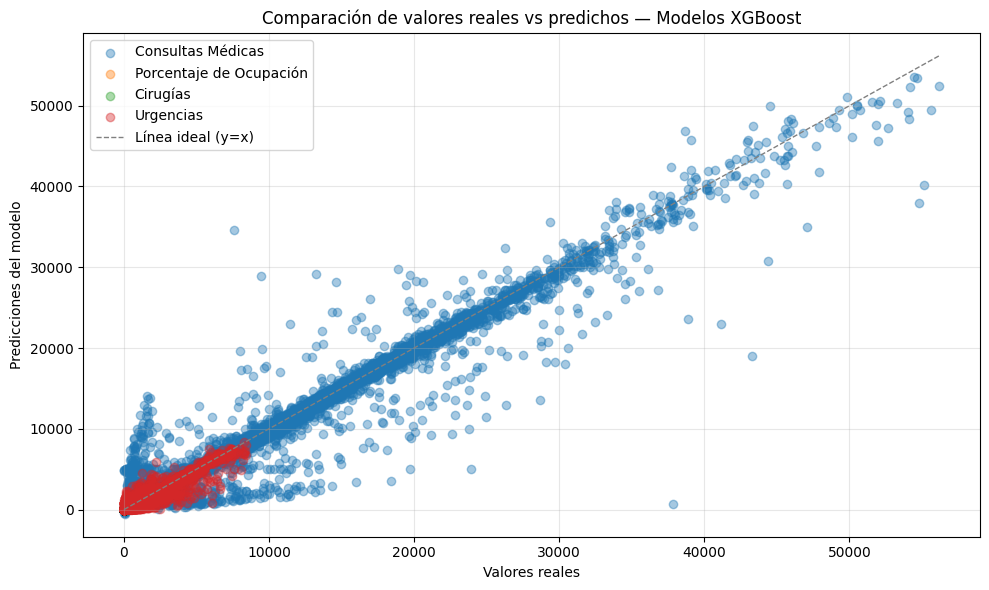

In [29]:
# ===============================================================
# 7. Comparación visual — Reales vs Predicciones
# ===============================================================

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.scatter(
    y_test_c,
    model_consultas.predict(X_test),
    alpha=0.4,
    label="Consultas Médicas",
    color="tab:blue",
)

plt.scatter(
    y_test_o,
    model_ocupacion.predict(X_test),
    alpha=0.4,
    label="Porcentaje de Ocupación",
    color="tab:orange",
)

plt.scatter(
    np.expm1(y_test_s),
    np.expm1(model_cirugias.predict(X_test)),
    alpha=0.4,
    label="Cirugías",
    color="tab:green",
)

plt.scatter(
    y_test_u,
    model_urgencias.predict(X_test),
    alpha=0.4,
    label="Urgencias",
    color="tab:red",
)

max_val = max(
    y_test_c.max(),
    y_test_o.max(),
    np.expm1(y_test_s).max(),
    y_test_u.max(),
)

plt.plot(
    [0, max_val],
    [0, max_val],
    color="gray",
    linestyle="--",
    linewidth=1,
    label="Línea ideal (y=x)",
)

plt.xlabel("Valores reales")
plt.ylabel("Predicciones del modelo")
plt.title("Comparación de valores reales vs predichos — Modelos XGBoost")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

*El gráfico muestra cómo se comparan los valores reales con las predicciones de los modelos de consultas médicas, ocupación, cirugías y urgencias.
Cuando los puntos están cerca de la línea diagonal, significa que las predicciones son acertadas.
En este caso, la mayoría de los puntos están alineados con esa línea, lo que indica que los modelos funcionan bien y logran estimar los valores reales con buena precisión.
Las pequeñas diferencias que se ven son normales y reflejan la variación natural entre hospitales o meses*

In [30]:
# ===============================================================
# 8. Exploración de hospitales activos
# ===============================================================

mem = pd.read_csv("proyecciones_filtradas.csv")

print("Hospitales únicos:", mem["establecimiento_nombre"].nunique())
print(mem["establecimiento_nombre"].dropna().unique()[:20])

Hospitales únicos: 341
['ASILO Y UNIDAD SANITARIA DR. ALBERT SCHWEITZER'
 'CENTRO DE ALTA COMPLEJIDAD CARDIOVASCULAR PTE. J.D. PERON'
 'CENTRO DE ATENCION PRIMARIA DE LA SALUD URI RAMON CARRILLO'
 'CENTRO DE DIA'
 'CENTRO DE DIAGNOSTICO Y TRATAMIENTO  N° 1 DR. JAVIER SABATO'
 'CENTRO DE MEDICINA PREVENTIVA ZONA NORTE'
 'CENTRO DE SALUD DR. ARANA RIO TALA' 'CENTRO DE SALUD DR. HORACIO CANESI'
 'CENTRO DE SALUD SAN MANUEL' 'CENTRO GERIATRICO DR. ERNESTO L. PINTO'
 'CENTRO GERIATRICO HOSTAL DE LOS ABUELOS'
 'CENTRO MUNICIPAL DE SALUD DEL PARTIDO DE TRES ARROYOS (EX HOGAR DR. IGNACIO PIROVANO)'
 'CENTRO PROVINCIAL DE ATENCION - GONZALEZ CATAN (LA MATANZA)'
 'CENTRO PROVINCIAL DE ATENCION - PIGUE (SAAVEDRA)' 'CIC SALTO'
 'CIC SAN PEDRO' 'CLINICA Y MATERNIDAD MUNICIPAL GONZALEZ CHAVES'
 'ENTE DESCENTRALIZADO HOSPITAL DR. ANGEL MARZETTI'
 'GERIATRICO MUNICIPAL ALBERTO MENDITEGUY'
 'HOGAR DE ANCIANOS ARNALDO INCHAUSPE']


## 🧩 Conclusión General del Proyecto

El sistema desarrollado logra cumplir con el objetivo principal de predecir la demanda hospitalaria en distintos servicios clave — consultas médicas, porcentaje de ocupación, cirugías y urgencias — a partir de datos históricos y variables externas como el clima, los feriados y los efectos del COVID-19.

Los modelos entrenados con XGBoost demostraron un buen nivel de precisión y generalización, con métricas estables y sin señales de sobreajuste. Esto significa que las predicciones se mantienen consistentes tanto en los datos de entrenamiento como en los de prueba, lo cual refuerza su confiabilidad para el uso práctico.

El análisis anual y los gráficos de comparación entre valores reales y predichos muestran que las estimaciones siguen de cerca las tendencias observadas, capturando correctamente los patrones estacionales y las variaciones de demanda.

En conjunto, el modelo y la API creada permiten anticipar la presión sobre los recursos hospitalarios (camas, personal, quirófanos) y facilitar la planificación operativa y de insumos

| Variable | Error Medio (MAE) | R² | Evaluación |
|-----------|------------------|----|-------------|
| Consultas Médicas | 593.3 | 0.96 | Buen rendimiento |
| % de Ocupación | 0.29 | 0.90 | Resultados confiables |
| Cirugías (log) | 0.16 | 0.94 | Predicciones estables |
| Urgencias | 109.4 | 0.93 | Buen nivel de precisión |

En general, los resultados obtenidos permiten anticipar la demanda hospitalaria mensual con bastante exactitud, lo que puede ser de gran ayuda para planificar turnos, asignar personal y prever el uso de quirófanos y recursos médicos.  
Este tipo de predicciones mejora la capacidad de los hospitales para responder ante aumentos o disminuciones en la demanda y evitar tanto la saturación como el desperdicio de recursos.